## Create CSV files for AnDA

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime

# Custom
import functions as f
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir', 'numobs'] 
additional_info    = ['sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'fcor_boost' : 1,         
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':     '/home/arthur/results/TCsLifeMonitFromObs/descriptive_stats/',
    'save_csv_path': '/home/arthur/scripts/TCsLifeMonitFromObs/AnDA/AnDA_data/IBTrACS_V6/',
}

In [3]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])

ds_ibt                  = ds_ibt_raw[params_of_interest]
ds_ibt[additional_info] = ds_ibt_raw[additional_info].astype(str, copy=False) # Convert byte arrays to strings
# ds_ibt_raw

In [4]:
# ### FILTERS
# # Convert to m/s and km units
# ds_ibt['usa_wind']    *= 0.5144
# ds_ibt['storm_speed'] *= 0.5144
# ds_ibt['usa_r34']     *= 1.852
# ds_ibt['usa_rmw']     *= 1.852

# ### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# # By year
# start_date = np.datetime64('2000-01-01')
# fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
# ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# # Average by quadrant (R34 assumption) 
# # ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True) # Relax this assumption to study the asymmetry
# # By category
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_wind']
#     if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
#         ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
# for s in tqdm(range(len(ds_ibt['storm']))):
#     da = ds_ibt.isel(storm=s)['usa_rmw']
#     # Longest valid sequence
#     # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
#     #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
#     # Number of valid values
#     if np.count_nonzero(~np.isnan(da)) < 24: # Count the number otimestep_since_17msf valid usa_rmw values and filter it out if less than 24 values
#         ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# # Drop NaNs
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# # Add Time step since 17.5 m/s have been achieved
# ds_ibt['timestep_since_17ms'] = ds_ibt['usa_lon'] * 0
# ds_ibt['initial_r17']         = ds_ibt['numobs'] * 0
# for s in tqdm(range(len(ds_ibt.storm))):
#     ds = ds_ibt.isel(storm=s)
#     timestep_of_17ms = int(np.where(ds['usa_wind'] > 17.5)[0][0])
#     initial_r17      = float(ds_ibt.isel(storm=-1)['usa_r34'].mean(dim='quadrant', skipna=True)[timestep_of_17ms + 1]) # t + 1 to ensure a value is defined
#     ds_ibt['timestep_since_17ms'][s] = ds.date_time - timestep_of_17ms
#     ds_ibt['initial_r17'][s]         = initial_r17  

# print("Total samples after (1): ", len(ds_ibt['storm']))

# ### 2) FINAL DATASET
# ### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# # Both for RMW and R34
# life_cyc_percent_thresh = 0.6

# for s in tqdm(range(len(ds_ibt['storm']))):
#         ds      = ds_ibt.isel(storm=s)
#         # Compute life cycle length
#         cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
#         for param in ['usa_r34', 'usa_rmw']:
#         # for param in ['usa_rmw']:
#             # Compute length of longest valid sequence
#             val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
#             if val_len < life_cyc_percent_thresh * cyc_len:
#                 # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
#                 ds[param] *= np.nan
                
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
# ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

# print("Total samples after (2): ", len(ds_ibt['storm'])) 

# ### 3) ADD CORIOLIS
# ds_ibt['fcor'] = f.coriolis(np.abs(ds_ibt['usa_lat'])) * PARAMS['fcor_boost']
                
# ### 4) FLIP TCs of Southern hemisphere
# ### Take the symmetric with respect to Equator
# ### So storm_dir = PI - storm_dir
# ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# # Then project to (u, v) ref.
# ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
# ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))
# # plt.hist(np.array(ds_ibt['u_trans']).flatten()) # Check gaussianity

# ### 5) COMPUTE RMAX_CK22
# ds_ibt['rmax_ck22'] = f.get_rmax_ck22(
#     Vmax=ds_ibt['usa_wind'], R17=ds_ibt['usa_r34'], fcor=f.coriolis(np.abs(ds_ibt['usa_lat'])), 
#     intercept=0.459, coef1=0.00534, coef2=-0.00337
# ) / 1000

In [5]:
# ### SAVE
# ds_ibt.to_netcdf(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')

In [6]:
# ### OPEN
ds_ibt = xr.open_dataset(PATHS['save_path'] + 'ds_ibtracs_ALL.nc')
# ds_ibt

In [7]:
### FILTERS
# Rmax selection
# ds_ibt = ds_ibt.where(ds_ibt['usa_rmw'] < 50, drop=True)
# Latitude selection
ds_ibt = ds_ibt.where(ds_ibt['fcor'] < f.coriolis(30), drop=True)
# Outliers
# ds_ibt = ds_ibt.where(ds_ibt['name'] != 'NADINE', drop=True) # NADINE (2012) reintensifies at the end of its life cycle, leading to very high timestep since 17.5 m/s
# NB: this is not the only example: Florence, Dorian, Winston... 
# Thus,  one possibility is to constrain this delay to be not too long:
# ds_ibt = ds_ibt.where(ds_ibt['timestep_since_17ms'] < 50)

In [8]:
### COMPUTE V_STAR AND T_STAR AND CALIBRATE ALL THE STORMS ON THESE
list_of_vars = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'mean_r34', 'usa_rmw', 'storm_dir', 'storm_speed', 'lon', 'lat', 'timestep_since_17ms',\
               'basin', 'fcor', 'u_trans', 'v_trans', 'rmax_ck22', 'mean_rmax_ck22',
               ]

### COMPUTE v*, and t*
ds_ibt['v_star']     = ds_ibt['usa_wind'].max(dim='date_time', skipna=True)
v_star_idxs          = ds_ibt['usa_wind'].argmax(dim='date_time', skipna=True)
ds_ibt['t_star_idx'] = v_star_idxs # i.e the first index where usa_wind = LMI, no matter the NaNs
ds_ibt['t_star']     = ds_ibt['time'][:, v_star_idxs]
t34_idxs             = np.abs(ds_ibt['timestep_since_17ms']).argmin(dim='date_time', skipna=True)
ds_ibt['t34_idx']    = t34_idxs # i.e the first index where usa_wind = 34kts, no matter the NaNs
# Add Time step since v_star has been achieved
ds_ibt['timestep_since_v_star'] = ds_ibt['usa_lon'] * 0
for s in tqdm(range(len(ds_ibt.storm))):
    ds = ds_ibt.isel(storm=s)
    timestep_of_v_star = int(np.where(ds['usa_wind'] == float(ds['v_star']))[0][0])
    ds_ibt['timestep_since_v_star'][s] = ds.date_time - timestep_of_v_star

# Delete sequences
ds_temp  = ds_ibt.where(ds_ibt['t_star_idx'] - ds_ibt['t34_idx'] >= 20, drop=True) # Delete sequences where end idx is lower than seq_len
    
# Select between 34kts and V*
ds_final = ds_temp.where((ds_temp['timestep_since_17ms'] >= 0) & (ds_temp['timestep_since_v_star'] <= 0), drop=True)

# Mean R34 and Rmax_CK22
ds_final['mean_r34']       = ds_final['usa_r34'].mean(dim='quadrant', skipna=True) # mean R34
ds_final['mean_rmax_ck22'] = ds_final['rmax_ck22'].mean(dim='quadrant', skipna=True) # mean R34

  0%|          | 0/564 [00:00<?, ?it/s]

In [9]:
### ASSIGN CK/CD
ds_final['ER11']  = ds_final['usa_rmw'] * 1000 * ds_final['usa_wind'] / (ds_final['mean_r34'] * 1000 * 17.5 + 0.5 * ds_final['fcor'] * ((ds_final['mean_r34'] * 1000) ** 2))
ds_final['ck_cd'] = ds_final['usa_rmw'] * 0
for s in tqdm(range(len(ds_final.storm))):
    ds = ds_final.isel(storm=s)
    for dt in range(len(ds.date_time)):
        dst   = ds.isel(date_time=dt)
        if dst['ER11'].notnull():
            ck_cd = f.fit_Ck_Cd_eq38(float(dst['ER11']))
            if ck_cd < 2.5:
                ds_final['ck_cd'][s, dt] = float(ck_cd)
            else:
                ds_final['ck_cd'][s, dt] = np.nan
        else:
            ds_final['ck_cd'][s, dt] = np.nan

  0%|          | 0/383 [00:00<?, ?it/s]

/home/arthur/scripts/TCsLifeMonitFromObs/functions.py:23: RuntimeWarning: invalid value encountered in power
  return (0.5 * Ck_Cd) ** (1 / (2 - Ck_Cd))


In [10]:
### ASSIGN BASIN AS STRING
ds_final['basin_as_str'] = ds_final['basin'][:, 0]
for s in tqdm(range(len(ds_final.storm))):
    ds = ds_final.isel(storm=s)
    for dt in range(len(ds.date_time)):
        bsn = ds['basin'][dt].item()
        if bsn != '':
            break
        else:
            continue
    ds_final['basin_as_str'][s] = bsn

  0%|          | 0/383 [00:00<?, ?it/s]

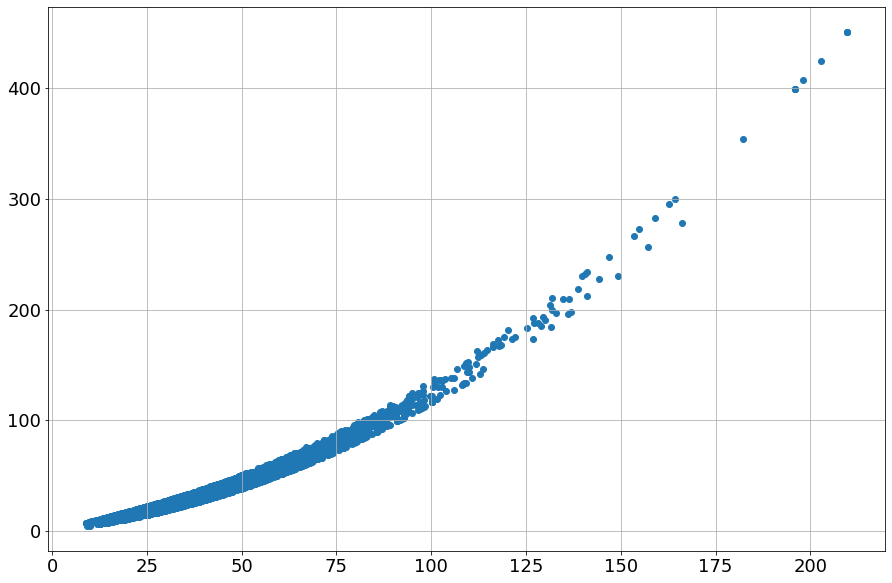

In [11]:
### Corrected Rmax_CK22
ds_final['rmax_ck22_corrected'] = ds_final['mean_rmax_ck22'] / (1 + 30 / ds_final['usa_wind'])
ds_final['rmax_ck22_corrected'] = ds_final['rmax_ck22_corrected'] * (1 + (ds_final['rmax_ck22_corrected']) / (1 * ds_final['usa_wind']))
plt.scatter(ds_final['mean_rmax_ck22'], ds_final['rmax_ck22_corrected']);plt.grid()

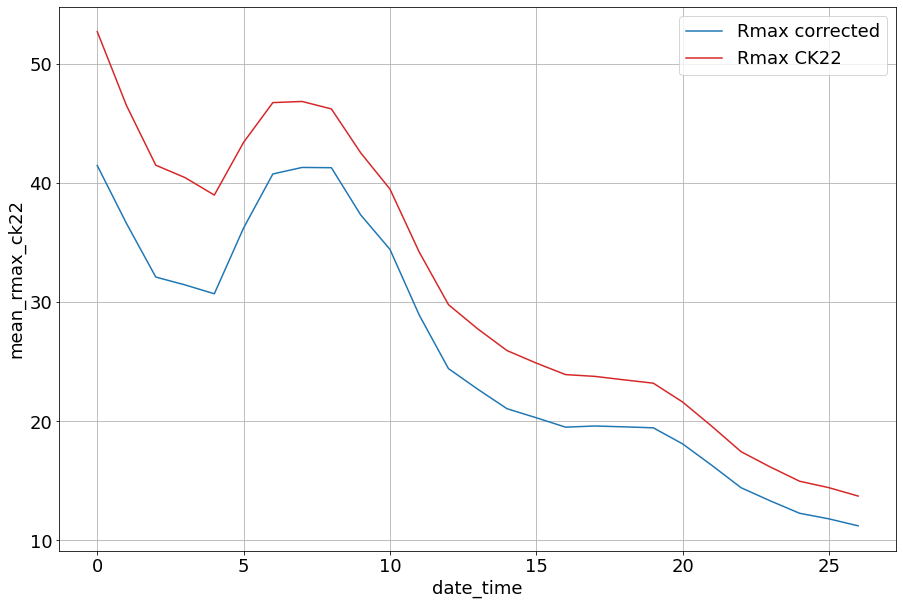

In [25]:
ds_final.where(ds_final['name'] == 'JEBI', drop=True)['rmax_ck22_corrected'].plot(c='tab:blue', label='Rmax corrected')
ds_final.where(ds_final['name'] == 'JEBI', drop=True)['mean_rmax_ck22'].plot(c='tab:red', label='Rmax CK22')
plt.grid();plt.legend()

In [28]:
### Newer version with Rmax_CK22_crr
def create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans']):
    # print('Creating dataset...')
    X   = [] # shape (n_time, n_params)
    fin_par_with_diff = final_params + ['{}_diff'.format(p) for p in final_params]
        
    # Add derivatives
    for p in final_params:
        ds['{}_diff'.format(p)]     = ds[p] * np.nan
        ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
    # Get only valid stime steps
    ds         = ds.dropna(dim='date_time', subset=fin_par_with_diff)

    # Add to X and Y dataset
    da         = ds[fin_par_with_diff].to_array().transpose()
    for t in range(len(da['date_time'])):
        X.append(da[t, :].values)
    
    # Convert to arrays
    X   = np.array(X)
    return X

### SAVE CSV FILES - With Ck/Cd
for s in tqdm(range(len(ds_final.storm))):
    ds         = ds_final.isel(storm=s)
    nme        = ds['name'].where(ds['name'].notnull(), drop=True)[0].item()
    sid        = ds['sid'].where(ds['sid'].notnull(), drop=True)[0].item()
    filename   = nme + '_' + sid
    # X_TC       = create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans'])
    X_TC       = create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans', 'rmax_ck22_corrected'])
    if len(X_TC) > 0:
        # X_TC       = X_TC[:, [0, 1, 2, 3, 4, 5, 6]] # Select parameters
        X_TC       = X_TC[:, [0, 1, 2, 7, 3, 4, 5, 6]] # Select parameters
        df         = pd.DataFrame(X_TC)
        # df.columns =  ['Vmax', 'Rmax_IBT', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']
        df.columns =  ['Vmax', 'Rmax_IBT', 'Rmax_CK22', 'Rmax_CK22_crr', 'R34', 'fcor', 'u_trans', 'v_trans']
        df.to_csv(PATHS['save_csv_path'] + filename, index=False)

  0%|          | 0/383 [00:00<?, ?it/s]

In [ ]:
# ### SAVE CSV FILES
# def create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans']):
#     # print('Creating dataset...')
#     X   = [] # shape (n_time, n_params)
#     fin_par_with_diff = final_params + ['{}_diff'.format(p) for p in final_params]
        
#     # Add derivatives
#     for p in final_params:
#         ds['{}_diff'.format(p)]     = ds[p] * np.nan
#         ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
#     # Get only valid stime steps
#     ds         = ds.dropna(dim='date_time', subset=fin_par_with_diff)

#     # Add to X and Y dataset
#     da         = ds[fin_par_with_diff].to_array().transpose()
#     for t in range(len(da['date_time'])):
#         X.append(da[t, :].values)
    
#     # Convert to arrays
#     X   = np.array(X)
#     return X

# ### SAVE CSV FILES - With Ck/Cd
# for s in tqdm(range(len(ds_final.storm))):
#     ds         = ds_final.isel(storm=s)
#     nme        = ds['name'].where(ds['name'].notnull(), drop=True)[0].item()
#     sid        = ds['sid'].where(ds['sid'].notnull(), drop=True)[0].item()
#     filename   = nme + '_' + sid
#     X_TC       = create_csv_file(ds, final_params=['usa_wind', 'usa_rmw', 'mean_rmax_ck22', 'mean_r34', 'fcor', 'u_trans', 'v_trans'])
#     if len(X_TC) > 0:
#         X_TC       = X_TC[:, [0, 1, 2, 3, 4, 5, 6]] # Select parameters
#         df         = pd.DataFrame(X_TC)
#         df.columns =  ['Vmax', 'Rmax_IBT', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']
#         df.to_csv(PATHS['save_csv_path'] + filename, index=False)